In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# GLOBAL DECLEARATIONS

In [0]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import scipy.signal as scsig
from scipy.io import loadmat
from scipy.signal import medfilt
import pywt
from pywt import wavedec
#from ecgdetectors import Detectors
#import hrv
import matplotlib
import matplotlib.pyplot as plt
#from PIL import Image
import matplotlib.ticker as ticker
# dbname_mat folders exist here
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
print('GLOBAL DATA DIR :: '+global_dir)

# dbname_npy shoud exsist
global_npydir = os.path.join(global_dir, 'db_npy') #global_dir + 'db_npy/'
print('GLOBAL NPY DIR :: '+global_npydir)

# dbname_npy shoud exsist
global_modeldir = os.path.join(global_dir, 'model_data') 
print('GLOBAL MODEL DIR :: '+global_modeldir)

global_datadir = os.path.join(global_npydir, 'data_npy') 
print('GLOBAL DATA DIR :: '+global_datadir)

# global annotation and mapping, common for all ECG from https://physionet.org/about/database/
global_annot = os.path.join(global_dir, 'annotations.txt' )  
print('GLOBAL ANNOTATIONS :: '+global_annot)
# view this file on drive :: https://drive.google.com/open?id=1edhzatX7D3Uo03-d08Lksp807ULlcpgo

#===================================================================================================================
# load MIT annotation mapping  

g_MIT_AMAP_data = np.loadtxt(global_annot, dtype='str',delimiter="\t")
g_MIT_AMAP={}
print('')
for a in g_MIT_AMAP_data:
    g_MIT_AMAP[a[0]]= int(a[1])
    print(str(a[0])+'\t'+str(a[1])+'\t'+str(a[2]))
    #a[0] = orignal mit label (char)
    #a[1] = mapped integer label (int)
    #a[2] = description (str)
print('')
map_keys = g_MIT_AMAP.keys()
map_vals = g_MIT_AMAP.values()

print('DB Labels : ' + str(map_keys))
#print(' :: STD LABEL MAPPING :: ')
#for k in map_keys:
    #print(k+'\t'+str(g_MIT_AMAP[k]))
#print(g_MIT_AMAP)

#maxlabels=max(map_vals)+1
print('NOS DB Label = '+ str(len(map_keys)))

g_COLORS = ['green','red']
g_LABELS = np.array(['N','A'])
g_COUNT = len(g_LABELS)
print('STD Labels : ' + str(g_LABELS))
print('NOS STD Label = '+ str(g_COUNT))
#===================================================================================================================
print(datetime.datetime.now())
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='int')
    for i in range(0, len(peak_label)):
        res[i] = g_MIT_AMAP[peak_label[i]]
    return res

def print_dict(name, dict_to_print, sep):
    print('\n--> DICT :: '+ str(name))
    for ki in dict_to_print.keys():
        print(str(ki)+sep+str(dict_to_print[ki]))
    print('<------- END')
    return 0
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name

        #self.dirs = db.get_dirs(recname)            # dict              dict of npy data file names to be loaded in data dict used in self.load_data('key')
        self.data = {}                              # dict              dict of npy data file content used in self.read_data('key')

        # find the gain
        self.info = get_minfo(os.path.join(db.dir_mat,recname+'m.hea'))#,db.lead2_index+1)  # head has this info at lead2's index
        self.gain = int(self.info[db.lead2_index+1].split()[2].split('/')[0])
        self.gain5 = int(self.info[db.lead5_index+1].split()[2].split('/')[0])
        #print(self.info)
    
    def print_info(self):
        res = ''
        for i in range(0,len(self.info)):
            res+= self.info[i]
        return res

    def read_data(self, data_type):
        if data_type in self.data.keys():
            return self.data[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

    def save_data(self, data_type, data_array):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
        except:
            print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            raise Exception("File not found")
        finally:
            return self.data[data_type] #= np.load(self.dirs[s])
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  sampling_rate, lead2_index, lead5_index, exclude_rec):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #int
        self.lead2_index = lead2_index #int
        self.lead5_index = lead5_index #int
        #self.dir_raw = global_dir + dbname+'_raw/' #str
        self.dir_mat = os.path.join(global_dir , dbname+'_mat') #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs_all = set(np.loadtxt(os.path.join(self.dir_mat,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_exc = set(exclude_rec)
        self.recs = set.difference(self.recs_all, self.recs_exc) 
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'MAT DIR :: ' + self.dir_mat )
        print( 'NPY DIR :: ' + self.dir_npy )
        print( 'S_RATE :: ' + str(self.srate))
        print( 'LEAD2 INDEX  :: ' + str(self.lead2_index))
        print( 'LEAD5 INDEX  :: ' + str(self.lead5_index))
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        return ecg_record(self,rec)

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# Pre processing Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    if res % 2 == 0 : # is even
        res+=1 # make odd
    return res

def filter_signal(X,mfltrs_array):
    X0 = X  #read orignal signal
    for mi in range(0,len(mfltrs_array)):
        X0 = medfilt(X0,mfltrs_array[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

def get_minfo(minfo_path):
    f = open(minfo_path,'r')
    ls = f.readlines()
    f.close()
    #la = ls[minfo_line_index].split()    #I67m.mat 16+192 623/mV 16 0 4441 1894 0 II
    return ls # gain at 2 baseline at 4

#---------------------------------------------------------------------------------------------------------------------------------------------

def view_beat(binf, ffigure, dotpi):
    #binfs = "['mitdb' '208' '424321' '424510' '424699' 'N' '0' '0' '189' '189' '0']"
    #binf = binfs[1:-1].split(" ")
    #for i in range(0,len(binf)):
    #    binf[i] = binf[i][1:-1]
    #    #print(binf[i])
    #print ('VIEW BEAT : '+ str(binf))


    #sigval, peak, label, len_arr, len_time, RRp, RRn = get_signal(  binf, all_db, True, 3, True)
    sigval, peak, label, len_arr, len_time, rpp, rp, rn, rnn = get_signal(  binf, all_db, True, 3, True)

    print("Array Len = " +str(len_arr))
    print("Array RRpp = " +str(rpp))
    print("Array RRp = " +str(rp))
    print("Array RRn = " +str(rn))
    print("Array RRnn = " +str(rnn))

    print("Time Dur = " +str(len_time))
    print("Time RRp = " +str(rp/BASIC_SAMPLING_RATE))
    print("Time RRn = " +str(rn/BASIC_SAMPLING_RATE))


    plt.figure(ffigure, figsize=(len_time*4,6), dpi=dotpi)
    plt.ylim(-2.5,2.5)
    plt.xlim(0-1,len_arr+1)
    plt.vlines(peak, -2.5,2.5,linestyles='dotted',linewidth=0.4)
    plt.plot(sigval, label='L2', linewidth=0.4, color='black')
    plt.title(str(binf)+'::'+ str(len_time)+ 'sec' )
    plt.legend()
    return


GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/model_data
GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_npy
GLOBAL ANNOTATIONS :: /content/drive/My Drive/Masters/workdir/ecg_data/annotations.txt

N	0	Normal beat
L	0	Left bundle branch block beat
R	0	Right bundle branch block beat
B	-1	Bundle branch block beat (unspecified)
A	1	Atrial premature beat
a	1	Aberrated atrial premature beat
J	1	Nodal (junctional) premature beat
S	1	Supraventricular premature or ectopic beat (atrial or nodal)
V	1	Premature ventricular contraction
r	1	R-on-T premature ventricular contraction
F	1	Fusion of ventricular and normal beat
e	1	Atrial escape beat
j	1	Nodal (junctional) escape beat
n	1	Supraventricular escape beat (atrial or nodal)
E	1	Ventricular escape beat
/	-1	Paced beat
f	-1	Fusion of paced and normal be

# DB DICT CREATION

In [0]:
# def __init__(self, dbname,  sampling_rate, lead2_index):
all_db = {}

mitdb_ex = [
            '102', '104', '107', '217',     # contains paced beats
            '212', '231',                   # contains both Normal and BBB type beats
            '207'                           # contains both RBBB and LBBB type beats
            ]
all_db['mitdb'] = ecg_db('mitdb', 360, 0, 1, mitdb_ex )

svdb_ex = []
all_db['svdb'] = ecg_db('svdb',  128, 0, 1,svdb_ex)

incartdb_ex = []
all_db['incartdb'] = ecg_db('incartdb', 257, 1, 10,incartdb_ex)
#print(all_db.values())
print('')
print(all_db.keys())


#------------------------- signal data types--------------------
g_ANT_POSTFIX = 'ant'

g_RAW2_POSTFIX = 'raw2'
g_RAW5_POSTFIX = 'raw5'

g_MED2_POSTFIX = 'med2'
g_MED5_POSTFIX = 'med5'

g_DEN2_POSTFIX = 'den2'
g_DEN5_POSTFIX = 'den5'

g_FLT2_POSTFIX = 'flt2'
g_FLT5_POSTFIX = 'flt5'
#------------------------- signal data types--------------------


#heart -rate params
H_min = 30
H_low = 60
H_hig = 100
H_max = 200
min_rri = 60/H_min
max_rri = 60/H_max
low_rri = 60/H_low
hig_rri = 60/H_hig

BASIC_SAMPLING_RATE = 128 #Hz
beat_cut_time = 5 #sec  -> if prev or next R peak is not within this range then its cut off at this point
timesteps =2* beat_cut_time * BASIC_SAMPLING_RATE + 0
def get_signal(binfo, db_dict, do_normalize, round_up, resamp):  # all_db
    #print(binfo)
    b_db = str(binfo[0])
    b_rec = str(binfo[1])
    b_begin = int(binfo[2])
    b_peak = int(binfo[3])
    b_end = int(binfo[4])
    b_label = str(binfo[5])

    b_peakpp = int(binfo[11])
    b_peakp = int(binfo[8])
    b_peakn = int(binfo[9])
    b_peaknn = int(binfo[12])

    e_rec = db_dict[b_db].get_record(b_rec) # is an 'ecg_record' object
    #print('selected record ' + str(e_rec.name))
    #RR_prev = (b_peak - b_begin) / e_rec.db.srate #sec RRp
    #RR_next = (b_end - b_peak) / e_rec.db.srate #sec RRn
    # 3 load record data and params 
    #med5 = e_rec.read_data(g_MED5_POSTFIX)[b_begin:b_end]    # Lead V5 data
    med2 = e_rec.read_data(g_MED2_POSTFIX)[b_begin:b_end]    # Lead II
    len_ind = len(med2)
    len_sec = round(len_ind/e_rec.db.srate, round_up)
    peak_location = b_peak - b_begin
    if resamp:
        med2 = scsig.resample(med2, round(len_ind*BASIC_SAMPLING_RATE/e_rec.db.srate))
        len_ind = len(med2)
        len_sec = round(len_ind/BASIC_SAMPLING_RATE, round_up)
        peak_location = round(peak_location*BASIC_SAMPLING_RATE/e_rec.db.srate)
        b_peakpp = round(b_peakpp*BASIC_SAMPLING_RATE/e_rec.db.srate)
        b_peakp = round(b_peakp*BASIC_SAMPLING_RATE/e_rec.db.srate)
        b_peakn = round(b_peakn*BASIC_SAMPLING_RATE/e_rec.db.srate)
        b_peaknn = round(b_peaknn*BASIC_SAMPLING_RATE/e_rec.db.srate)
    if do_normalize:
        #med5 = np.multiply(med5,[1/e_rec.gain])
        med2 = np.multiply(med2,[1/e_rec.gain])

    
    return med2, peak_location, b_label, len_ind, len_sec, b_peakpp, b_peakp, b_peakn, b_peaknn


#------------------------- beat-info array structure --------------------
binfo_props = len([
                   '0_db', '1_rec', 
                   '2_begin', '3_peak', '4_end', 
                   '5_label', '6_int_label', '7_is_3N', 
                   '8_prev_RRi', '9_next_RRi','10_delta_RRi',
                   '11_prev2prev_RRi', '12_next2next_RRi','13_delta_2RRi',
                   ])


Initailze new ecg database ... 
DB NAME :: mitdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/mitdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
S_RATE :: 360
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [41] {'112', '234', '108', '220', '233', '114', '105', '101', '119', '209', '106', '221', '215', '115', '116', '109', '118', '113', '213', '201', '111', '222', '117', '208', '232', '210', '203', '200', '123', '103', '121', '205', '202', '214', '122', '219', '230', '223', '100', '124', '228'}

Initailze new ecg database ... 
DB NAME :: svdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/svdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
S_RATE :: 128
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [78] {'846', '888', '806', '843', '850', '891', '870', '808', '810', '812', '823', '848', '805', '877', '860', '890', '845', '840', '853', '876', '800', '869', '826', '868', '822', '863', 

# [ * ONE TIME * ] DB Building Functions

In [0]:

#---------------------------------------------------------------------------------------------------------------------------------------------
# Database Building Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 1 Build Annotations :: a.txt -> ant.npy
def build_db_ants(self_db, output_postfix):  
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    #xc=1
    print('\nBEGIN TASK :: Build annotations for ' + str(xs)+ ' records')
    print('REC\tFound\tKnown\tUnknown' )
    for rec in self_db.recs:
        #print('REC: '+rec+ '...'+str(xc)+ ' of '+ str(xs))
        #xc+=1
        ants = np.loadtxt(os.path.join(self_db.dir_mat , rec + 'a.txt'), dtype='str', delimiter= '\n', skiprows = 1)
        #print('\tFound Annotations\t'+str(len(ants)))
        antsnpy = np.zeros((0,2),dtype='str')
        #print('  annotations found '+str(len(ants)))
        for i in range(0,len(ants)):
            a_a = ants[i].split()
            a_sample = a_a[1]
            a_label = a_a[2]
            if (a_label in map_keys):
                antsnpy = np.vstack((antsnpy,np.array([a_sample,a_label]))) # sample,label str
            else:
                print('\tWARNING :: Unknown annotation "'+a_label+'" found at [' +a_sample+ '] in file a.txt, skipping....')
        
        adf =  len(ants) - len(antsnpy) 
        #print('\tKnown Annotations\t'+str(len(antsnpy)))
        # print('\tUnknown Annotations\t'+str(adf))
        print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsnpy))+'\t' + str(adf) )
        # save for this record
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix+'.npy'), antsnpy)
        #print('\tSaved at "'+save_loc+'"')
    print('\nEND TASK :: Build annotations for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 2 Extract Raw lead2 signal :: m.mat[lead2] -> raw2.npy
def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    print('\nBEGIN TASK :: Save signal data for ' + str(xs)+ ' records')
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        mat_signal = loadmat(os.path.join( self_db.dir_mat , rec + 'm.mat'))['val']#[self_db.lead2_index]
        for li in range(0,len(lead_indices)):
            np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix[li]+'.npy'), mat_signal[lead_indices[li]])    
    print('END TASK :: Save signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 3a Filter Raw/Denoised signal :: raw2.npy -> med2.npy or den2.npy -> rmd2.npy
def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    mfa = np.zeros(len(ms_flt_array), dtype='int')
    #print('fun')
    for i in range(0, len(ms_flt_array)):
        mfa[i] = get_median_filter_width(self_db.srate,ms_flt_array[i])
        #print('loop')
    print('\nBEGIN TASK :: filer signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy')) #np.save(rec_fnpy + '_raw2.npy', mat_signal) 
        X_med2 = filter_signal(X, mfa)
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_med2) # save a copy of (median filtered ) signal = r,m  
        #----------------------------------------------------------------------         
    print('END TASK :: filer signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 3b Denoise Raw/Filtered signal :: med2.npy -> rdm2.npy or raw2.npy -> den2.npy
def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    
    print('\nBEGIN TASK :: denoising signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy') ) # np.load(self_db.dir_npy + rec + '_raw2.npy')
        X_rlt2 = denoise_signal(X,dwt_transform, dlevels, cutoff_low, cutoff_high )
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_rlt2) # save a copy of (only denoised)  signal = r,m,d 
        #----------------------------------------------------------------------         
    print('END TASK :: denoising signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------


# [ * ONE TIME * ] DB Building

In [0]:
#    C A R E F U L   D O N T     R U N    T H I S 

approach = 0  # select Filtering approach


db_data = all_db.values()
print(datetime.datetime.now())
print('S T A R T \n')

for db in db_data:
#=========================================================================================
    print ('\n START ON DATABASE: '+ db.name +' \t'+ str(datetime.datetime.now())): 
    directory = os.makedirs(os.path.join(global_npydir, db.name+'_npy') , exist_ok = True) 
#=========================================================================================

#=========================================================================================
# STEP 0 : (REQUIRED : Annotation data)
#=========================================================================================
    print ('\n COPY ANNOTATIONS \t'+ str(datetime.datetime.now()))
    # def build_db_ants(self_db, output_postfix):
    build_db_ants(db, g_ANT_POSTFIX)  


#=========================================================================================
# STEP 1 : (REQUIRED : Signal Data)
#=========================================================================================
    print ('\n EXTRACT RAW SIGNAL \t'+ str(datetime.datetime.now()))
    # def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
    # use build_db_signal(db, [g_RAW?_POSTFIX],[db.lead?_index]) 
    build_db_signal(db, [g_RAW2_POSTFIX],[db.lead2_index])


#=========================================================================================
# STEP 3 : (Preprocessing)
#=========================================================================================

    if approach==0:
        # STEP 3.a : First 'median Filter' the signal then 'denoise' it
        #=========================================================================================
        print ('\n FILTER :: RAW -> MED \t'+ str(datetime.datetime.now()))
        # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
        filter_db_signal(db, [0.2,0.6], g_RAW2_POSTFIX, g_MED2_POSTFIX) 
        
        print ('\n DENOISE :: MED -> FLT \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED2_POSTFIX, g_FLT2_POSTFIX )

        
    else:
        # STEP 3.b : First 'denoise' the signal then 'median filter' it
        #=========================================================================================
        print ('\n DENOISE :: RAW -> DEN \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW2_POSTFIX, g_DEN2_POSTFIX )

        print ('\n FILTER :: DEN -> FLT \t'+ str(datetime.datetime.now()))
        # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix):  
        filter_db_signal(db, [0.2,0.6], g_DEN2_POSTFIX, g_FLT2_POSTFIX) 
        
    
#=========================================================================================
    print ('\n END ON DATABASE:'+ db.name +' \t'+ str(datetime.datetime.now()))
#=========================================================================================
print('\n E N D ')
print(datetime.datetime.now())
#    C A R E F U L   D O N T     R U N    T H I S 

# [ * ONE TIME * ] annotation mapping

In [0]:
# O
# 1 select random database or all using all_db.keys()
rand_db = all_db.keys() # ['mitdb' , 'svdb', 'incartdb']
for idbs in rand_db:
#idbs = rand_db[random.randint(0,2)]
    print(idbs)
    dbs = all_db[idbs]

    # 2 select random record
    reclist = list(dbs.recs)    # is a list of strings
    for irec in reclist:
        #irec = reclist[random.randint(0,len(reclist)-1)]  # should be a string
        print(irec)
        selrec = dbs.get_record(irec) # is an 'ecg_record' object
        print('selected record ' + str(selrec.name))
        srate = selrec.db.srate
        beat_cutoff_window = int(beat_cut_time*srate) #sec


        # 3 locate beats and non-beat annotations(RR-peaks)=========================================================================
        #   use mapstd(labels) : beat annotations map to 
        ant2 = selrec.load_data(g_ANT_POSTFIX)      # annotation data
        antm = mapstd(ant2[:,1])                    # map annotations to integer label [-2, -1, 0, 1, 2, 3 ... ]
        ant2_beats = ant2[antm>-2]                  # only RR peaks
        ant2_nonbeats = ant2[antm<=-2]              # only non beats
     


        beats_info = np.zeros((0, binfo_props),dtype='U10')
        for i in range(2, len(ant2_beats)-2): # exclude first2 and last2 beat
            ci = np.zeros(binfo_props,dtype='U10') 
            ci[0] = idbs            # db this beat belongs to
            ci[1] = irec            # record this beat belongs to

            RRpp = int(ant2_beats[i-2,0])     # prev 2 prev R peak
            RRp = int(ant2_beats[i-1,0])     # prev R peak
            RRi = int(ant2_beats[i,0])       # current R
            RRn = int(ant2_beats[i+1,0])     # next R peak
            RRnn = int(ant2_beats[i+2,0])     # next 2 next R peak


            # 8,9,10 are distance from prev and next R peak independend of beat_cutoff_window - #RRp RRn can change in windown fitting
            ci[8]=str(RRi - RRp)
            ci[9]=str(RRn - RRi)
            ci[10] = str(abs((RRi - RRp) - (RRn - RRi)))
            ci[11]=str(RRp - RRpp)
            ci[12]=str(RRnn - RRn)
            ci[13] = str(abs((RRp - RRpp) - (RRnn - RRn)))

            # chek if prev and next peaks are more than 2 secs
            delta_p = ( RRi - RRpp )  # seconds
            delta_n = ( RRnn - RRi ) 
            if delta_p > beat_cutoff_window : 
                RRpp = RRi-beat_cutoff_window
                print ("PREV WINDOW overflow: db="+ idbs+ ' | rec='+ irec + '| peak='+ str(RRi)+ ' | Pwin='+str(delta_p/srate))
            if delta_n > beat_cutoff_window : 
                RRnn = beat_cutoff_window+RRi
                print ("NEXT WINDOW overflow: db="+ idbs+ ' | rec='+ irec + '| peak='+ str(RRi)+ ' | Nwin='+str(delta_n/srate))

            ci[2] = str(RRpp)
            ci[3] = str(RRi)
            ci[4] = str(RRnn)
            
            ci[5] = ant2_beats[i,1]       # string label this contains beat annotations only

            bpP = g_MIT_AMAP[ant2_beats[i-1,1]]
            bpI = g_MIT_AMAP[ant2_beats[i,1]]
            bpN = g_MIT_AMAP[ant2_beats[i+1,1]]
            # if any one is abnormal i.e !=0 then mark abnormal #ci[6] = str(g_MIT_AMAP[ant2_beats[i,1]])
            if bpP==0 and bpI==0 and bpN==0:
                ci[6] = str(0)
            else:
                ci[6] = str(1)

            if g_MIT_AMAP[ant2_beats[i-2,1]] == 0 and g_MIT_AMAP[ant2_beats[i+2,1]] == 0:
                ci[7] = str(0)  #  surronded by 2 normal 
            else:
                ci[7] = str(1) # not surronded by 2 normal beats one or both may be abnormal

                # 6,7 =  0,0 means noraml surronded by 2 normal                 NN 0<---- not all only those who vary less in succ_rri
                #        0,1 means normal surronded by 1 or 2 abnormal          NA 1<------ we not selecting this for training
                #        1,0 means abnorm surronded by 2 normal                 AA 2
                #        1,1 means abnorm surronded by 1 or 2 abnormal          AA 2
            
            beats_info = np.vstack((beats_info,ci)) # stack it up

        print('Found beats: '+ str(beats_info.shape))
        print(selrec.save_data('ant_m2',beats_info))
#=============================================================================






mitdb
121
selected record mitdb_121
Found beats: (1859, 14)
/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy/121_ant_m2.npy
200
selected record mitdb_200
Found beats: (2597, 14)
/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy/200_ant_m2.npy
124
selected record mitdb_124
Found beats: (1615, 14)
/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy/124_ant_m2.npy
118
selected record mitdb_118
Found beats: (2274, 14)
/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy/118_ant_m2.npy
115
selected record mitdb_115
Found beats: (1949, 14)
/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy/115_ant_m2.npy
117
selected record mitdb_117
Found beats: (1531, 14)
/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy/117_ant_m2.npy
109
selected record mitdb_109
Found beats: (2528, 14)
/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy/109_ant_m2.npy
108
selected record mitdb_108
Found beats: (1759,

# Generate Global Dataset

Take fixed and equal amount of beats of Normal and Abnormal types from each record that has enough number of both beats ( has atleast twice the amount of 'beats_2_take' )

In [0]:
# 1 Generate a Name for global DS
global_dataset_name = 'b3b'
if global_dataset_name == '':
    global_dataset_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S')
global_dataset_name = 'GDS_' + global_dataset_name + '.npy'
savepath = os.path.join( global_datadir, global_dataset_name)

# 2 database to sleect from
rand_db = ['mitdb' , 'svdb', 'incartdb']

# 3 How many times to shuffle
#do_shuffle = 6

#print('DB_RECORD\tALL\t*N*\t*A*\t*X*\tSNN\tSAA\tRRI')
beats_taken = np.zeros((0,binfo_props),dtype='U10')


# DEFINE CRITERION FOR SELECTING BEATS
beats_2_take_N = 20 # must have 'beats_2_have_N' times this many beats of N type
beats_2_have_N = 2 # record must have 'beats_2_have_N' times that of 'beats_2_take_N' beats to be eligible to select from
succ_rri_for_N = 0.05 # if differnece in succesvie rri are more than this then its not normal
succ2_rri_for_N = 0.1
beats_2_take_A = 30 # must have 'beats_2_have_A' timmes this many beats of A type
beats_2_have_A = 1.2


print('DB__RECORD\tALL\tNNN\tAAA' ) 
for idbs in rand_db:  # in all databases  
    #print('working db ' + idbs)
    dbs = all_db[idbs]
    reclist = list(dbs.recs)    # is a list of strings
    for irec in reclist:        # in all records
        #print('\t' + irec)
        
        # select a record
        selrec = dbs.get_record(irec) # is an 'ecg_record' object
        srate = selrec.db.srate
        #print(selrec.name+'...')
        # load its mapped annotation
        beats_info=selrec.load_data('ant_m2')

        # extract location of R peaks
        #rr_samples =  beats_info[:,3].astype('int') # beats_info[:,3].astype('int')  # 3 for location of peak sample
        #nos_peaks = len(rr_samples)

        # Select Abnormal Beats
        beats_info_A = beats_info[(beats_info[:,6]=='1')] #<------ THIS IS A
        nos_A = len(beats_info_A)
        if nos_A >= beats_2_take_A*beats_2_have_A:
            sel_A = set([])
            while len(sel_A)<beats_2_take_A:
                sel_A.add(random.randint( 0, nos_A-1 ))
        else:
            print(selrec.name + '\t___\t___\t___' ) #print('   ...Not enough A beats to choose from ... skipped' )
            continue
                
        # calculate successive rri difference for each R peak
        succ_rri = np.multiply(beats_info[:,10].astype('int'),[1/ srate])
        succ2_rri = np.multiply(beats_info[:,13].astype('int'),[1/ srate])
        # select Normal beats
        beats_info_N = beats_info[
                                  (beats_info[:,7]=='0') & 
                                  (beats_info[:,6]=='0') & 
                                  (succ_rri <= succ_rri_for_N) &
                                  (succ2_rri <= succ2_rri_for_N)
                                  ] #<----- THIS IS N
        nos_N = len(beats_info_N)
        if nos_N >= beats_2_take_N*beats_2_have_N:
            sel_N = set([])
            while len(sel_N)<beats_2_take_N:
                sel_N.add(random.randint( 0, nos_N-1 ))
        else:
            print(selrec.name + '\t___\t___\t___' ) #print('   ...Not enough N beats to choose from ... skipped' )
            continue
        
        bs_N =  beats_info_N[list(sel_N)]
        bs_A = beats_info_A[list(sel_A)]
        nos_A = len(bs_A)
        nos_N = len(bs_N)
        # Selected both N and A beats not stack it
        beats_taken = np.vstack((beats_taken, bs_N, bs_A ) )
        print(selrec.name + '\t'+ str(nos_N+nos_A)+ '\t'+str(nos_N)+'\t'+str(nos_A) )
#-------------------------------------------------------------------------------------------
#print(beats_taken)
print('Total Beats = ' + str(len(beats_taken)))
#for i in range(0,do_shuffle):
#    random.shuffle(beats_taken)
print(beats_taken)
np.save(savepath,beats_taken)
print('\nSaved at '+savepath)


DB__RECORD	ALL	NNN	AAA
mitdb_112	___	___	___
mitdb_234	50	20	30
mitdb_108	50	20	30
mitdb_220	50	20	30
mitdb_233	50	20	30
mitdb_114	50	20	30
mitdb_105	50	20	30
mitdb_101	___	___	___
mitdb_119	50	20	30
mitdb_209	50	20	30
mitdb_106	50	20	30
mitdb_221	50	20	30
mitdb_215	50	20	30
mitdb_115	___	___	___
mitdb_116	50	20	30
mitdb_109	50	20	30
mitdb_118	50	20	30
mitdb_113	___	___	___
mitdb_213	50	20	30
mitdb_201	50	20	30
mitdb_111	___	___	___
mitdb_222	50	20	30
mitdb_117	___	___	___
mitdb_208	50	20	30
mitdb_232	___	___	___
mitdb_210	50	20	30
mitdb_203	50	20	30
mitdb_200	50	20	30
mitdb_123	___	___	___
mitdb_103	___	___	___
mitdb_121	___	___	___
mitdb_205	50	20	30
mitdb_202	50	20	30
mitdb_214	50	20	30
mitdb_122	___	___	___
mitdb_219	50	20	30
mitdb_230	___	___	___
mitdb_223	50	20	30
mitdb_100	50	20	30
mitdb_124	50	20	30
mitdb_228	50	20	30
svdb_846	___	___	___
svdb_888	50	20	30
svdb_806	50	20	30
svdb_843	50	20	30
svdb_850	___	___	___
svdb_891	50	20	30
svdb_870	50	20	30
svdb_808	50	20	30
svdb_810	50	

# Generate Local Dataset


Single Record

In [0]:
selrec = all_db['mitdb'].get_record('208') # is an 'ecg_record' objec
print(selrec.name)
if selrec.rec in selrec.db.recs_exc:
    print('ERROR:: this record is excluded...')
else:
    srate = selrec.db.srate
    beats_info=selrec.load_data('ant_m2')
    savepath = os.path.join( global_datadir, selrec.name + '_ALL.npy')
    print(len(beats_info))
    #print(beats_info)
    np.save(savepath,beats_info)
    # this simply copies mapped annotations '_ant_m2.npy'
    print(beats_info.shape)
    print(beats_info)

mitdb_208
2951
(2951, 14)
[['mitdb' '208' '46' ... '163' '156' '7']
 ['mitdb' '208' '209' ... '274' '328' '54']
 ['mitdb' '208' '483' ... '214' '197' '17']
 ...
 ['mitdb' '208' '648521' ... '214' '205' '9']
 ['mitdb' '208' '648735' ... '159' '293' '134']
 ['mitdb' '208' '648894' ... '312' '231' '81']]


Random

In [0]:
rand_db = ['mitdb' , 'svdb', 'incartdb']
idbs = rand_db[random.randint(0,2)]
dbs = all_db[idbs]
reclist = list(dbs.recs)    # is a list of strings
irec = reclist[random.randint(0,len(reclist)-1)]

selrec = dbs.get_record(irec) # is an 'ecg_record' objec
print(selrec.name)
srate = selrec.db.srate
beats_info=selrec.load_data('ant_m2')
savepath = os.path.join( global_datadir, selrec.name + '_ALL.npy')
print(len(beats_info))
#print(beats_info)
np.save(savepath,beats_info)
print(beats_info.shape)
print(beats_info)
# this simply copies mapped annotations '_ant_m2.npy'

selecting LOCAL beats of above selected record

In [0]:

#do_shuffle = 6

#print('DB_RECORD\tALL\t*N*\t*A*\t*X*\tSNN\tSAA\tRRI')
beats_taken = np.zeros((0,binfo_props),dtype='U10')


# DEFINE CRITERION FOR SELECTING BEATS
beats_2_take_N = 30 # must have 'beats_2_have_N' times this many beats of N type
beats_2_have_N = 2 # record must have 'beats_2_have_N' times that of 'beats_2_take_N' beats to be eligible to select from
succ_rri_for_N = 0.05 # if differnece in succesvie rri are more than this then its not normal
succ2_rri_for_N = 0.1
beats_2_take_A = 30 # must have 'beats_2_have_A' timmes this many beats of A type
beats_2_have_A = 1

is_sel_A=False
is_sel_N=False
# Select Abnormal Beats
beats_info_A = beats_info[(beats_info[:,6]=='1')] #<------ THIS IS A
nos_A = len(beats_info_A)
sel_A = set([])
if nos_A >= beats_2_take_A*beats_2_have_A:
    while len(sel_A)<beats_2_take_A:
        sel_A.add(random.randint( 0, nos_A-1 ))
    is_sel_A = True
else:
    print(selrec.name + '\t___\t___\t___' ) #print('   ...Not enough A beats to choose from ... skipped' )
    is_sel_A = False
  # calculate successive rri difference for each R peak

        
# calculate successive rri difference for each R peak
succ_rri = np.multiply(beats_info[:,10].astype('int'),[1/ srate])
succ2_rri = np.multiply(beats_info[:,13].astype('int'),[1/ srate])
# select Normal beats
beats_info_N = beats_info[
                            (beats_info[:,7]=='0') & 
                            (beats_info[:,6]=='0') & 
                            (succ_rri <= succ_rri_for_N) &
                            (succ2_rri <= succ2_rri_for_N)
                            ] #<----- THIS IS N
nos_N = len(beats_info_N)
sel_N = set([])
if nos_N >= beats_2_take_N*beats_2_have_N:
    while len(sel_N)<beats_2_take_N:
        sel_N.add(random.randint( 0, nos_N-1 ))
    is_sel_N = True
else:
    print(selrec.name + '\t___\t___\t___' ) #print('   ...Not enough N beats to choose from ... skipped' )
    is_sel_N = False

#print(sel_N)
#print(sel_A)
if is_sel_N and is_sel_A:
    bs_N =  beats_info_N[list(sel_N)]
    bs_A = beats_info_A[list(sel_A)]
    nos_A = len(bs_A)
    nos_N = len(bs_N)
    # Selected both N and A beats not stack it
    beats_taken = np.vstack((beats_taken, bs_N, bs_A ))
    print(selrec.name + '\t' +str(nos_N) ) #print(selrec.name + '\t'+ str(nos_N+nos_A)+ '\t'+str(nos_N)+'\t'+str(nos_A) )
    #print(bs_N)
    #print(bs_A)
#======================================================================================================
# selecting 50 local NNN beats
#======================================================================================================
    #print(beats_taken)
    print('Total Beats = ' + str(len(beats_taken)))
    #for i in range(0,do_shuffle):
     #   random.shuffle(beats_taken)
    #print(beats_taken)
    savepath = os.path.join( global_datadir, selrec.name + '_LOCAL.npy')
    np.save(savepath,beats_taken)
    print('\nSaved at '+savepath)
else:
    print('None Selected')



mitdb_208	30
Total Beats = 60

Saved at /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_npy/mitdb_208_LOCAL.npy


# View Binfo Structure

24 of 60
['mitdb' '208' '466107' '466491' '466891' 'N' '0' '0' '187' '197' '10'
 '197' '203' '6']
Array Len = 279
Array RRpp = 70
Array RRp = 66
Array RRn = 70
Array RRnn = 72
Time Dur = 2.18
Time RRp = 0.515625
Time RRn = 0.546875


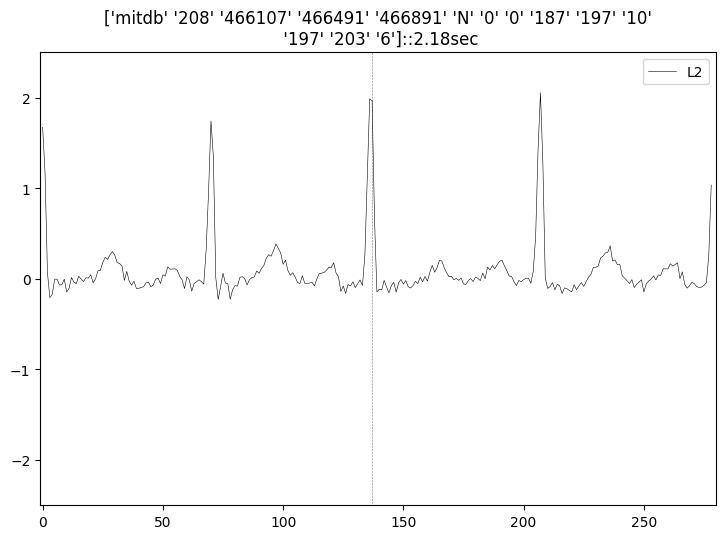

In [0]:
from_beats_array = beats_taken   # beats_info  beats_taken in_data
fbalen = len(from_beats_array)
rdii = random.randint( 0, fbalen-1 ) 
print(str(rdii)+ ' of '+ str(fbalen))
# generate random beat for viwing
rand_beatinfo = from_beats_array[ rdii ]
print(rand_beatinfo)
view_beat(rand_beatinfo,0,100)

# MODEL

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model, Sequential


print('Time-Steps: '+str(timesteps))
def get_shaped_data(d_train, time_steps):
    dlen = len(d_train)
    alld_l = d_train[:,1]
    alld_t = d_train[:,2:6]
    alld_m = d_train[:,6:]

    res_xM = alld_m.reshape((dlen,time_steps,1))
    res_xT = alld_t
    res_y =  alld_l
    return res_xM, res_xT, res_y
'''________________________________________________________________________



# PART 3 :: Prepare Network models - FNN and RNN


________________________________________________________________________'''


cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='acc', 
        min_delta=0.00001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] # for RNN

# 3.2 :: define network models

def getRNN(trainable_lstm):
    # Build and compile RNN model
    itempo=Input( shape=(4), name = "IN_TEMPO")
    denset=Dense(10, activation=tf.nn.relu, name = "DENSE_T")(itempo)

    imorph=Input( shape=(timesteps,1), name = "IN_MORPH")
    lstm1=LSTM(50,batch_input_shape=(timesteps,1),return_sequences=True, name = "LSTM_50")(imorph)
    lstm2=LSTM(150,return_sequences=False, name = "LSTM_150")(lstm1)
    densem=Dense(20, activation=tf.nn.leaky_relu, name = "DENSE_M")(lstm2)

    dconcat = tf.concat([denset,densem],axis=1, name = "CONCAT")
    densef=Dense(10, activation=tf.nn.relu, name = "DENSE_F")(dconcat)
    OPFC=Dense(2, activation=tf.nn.softmax, name = "OUTPUT_FC")(densef)

    model=Model(inputs=[imorph,itempo], outputs=OPFC)
    #-------------------------------------
    model.get_layer(name="LSTM_50").trainable=trainable_lstm
    model.get_layer(name="LSTM_150").trainable=trainable_lstm
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #print(model.summary())
    return model

def getRNN_notemp(trainable_lstm):
    # Build and compile RNN model
    #itempo=Input( shape=(4), name = "IN_TEMPO")
    #denset=Dense(10, activation=tf.nn.relu, name = "DENSE_T")(itempo)

    imorph=Input( shape=(timesteps,1), name = "IN_MORPH")
    lstm1=LSTM(50,batch_input_shape=(timesteps,1),return_sequences=True, name = "LSTM_50")(imorph)
    lstm2=LSTM(150,return_sequences=False, name = "LSTM_150")(lstm1)
    densem=Dense(20, activation=tf.nn.leaky_relu, name = "DENSE_M")(lstm2)

    #dconcat = tf.concat([denset,densem],axis=1, name = "CONCAT")
    densef=Dense(10, activation=tf.nn.relu, name = "DENSE_F")(densem) #(dconcat)
    OPFC=Dense(2, activation=tf.nn.softmax, name = "OUTPUT_FC")(densef)

    model=Model(inputs=imorph, outputs=OPFC)
    #-------------------------------------
    model.get_layer(name="LSTM_50").trainable=trainable_lstm
    model.get_layer(name="LSTM_150").trainable=trainable_lstm
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #print(model.summary())
    return model

# 3.3 :: define other misc functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res

#------------------------------------------------------------------PRINTING
g_LSTR=''   # HEADER ROW for printing confusing matrix
for i in range(0,g_COUNT):
    g_LSTR+='\t'+g_LABELS[i]

def print_cf_row(cf_row):
    res = ''
    for j in range(0,g_COUNT):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix):
    res=(suffix+'A\\P' + g_LSTR+'\n')
    for i in range(0,g_COUNT):
        res+=(suffix+g_LABELS[i] + print_cf_row(conf_matrix[i])+'\n')
    return res

def print_performance(perf_measures):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        #print ('\nPerf for Class: '+ g_LABELS[i])
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(g_LABELS[i]+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return


Time-Steps: 1280


# LOAD DATASET  [all_in_data]

In [0]:
dbfiles = os.listdir(global_datadir)
#print(dbfiles)
for i in dbfiles:
    print(i)

GDS_TEST_01.npy
mitdb_208_ALL.npy
mitdb_208_LOCAL.npy
GDS_b3b.npy


Load selecetd dataset to extract signal

In [0]:
sel_set = 'GDS_b3b' + '.npy'
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
# Extract signal below
sel_dbfile = os.path.join(global_datadir,sel_set)
in_data = np.load(sel_dbfile)
# 5000 x 11
z_len = 6
data_count = len(in_data)
all_in_data= np.zeros((0,timesteps+z_len))
print('working...')
for i in range(0,data_count):
    ib = in_data[i]
    if int(ib[6]) < 0:
        print('Found unmapped beat - cant use in evaluation...'+ str(ib))
        continue
    sigval, peak, label, len_arr, len_time, rpp, rp, rn, rnn = get_signal( ib, all_db, True, 3, True)
    #med2, peak_location, b_label, len_ind, len_sec, b_peakpp, b_peakp, b_peakn, b_peaknn
    if len(sigval)<10:
        print('WARNING: Signal window too low '+str(sigval))
    siglen = len(sigval)

    # How much to pad???
    ned2stack = timesteps-siglen
    leftstack = int(ned2stack/2)
    ritestack = int(ned2stack/2)
    ritestack += ned2stack%2  
    sigval = np.hstack((np.zeros(leftstack), sigval, np.zeros(ritestack) )) #<<<<<-------------------------- pad signal with zeros
    
    # Additional Temporal Information to be included
    tdata = np.array( [int(ib[3]), int(ib[6]), rpp, rp, rn, rnn], dtype ='float')

    # stack it up
    all_in_data = np.vstack( (all_in_data, np.hstack( (tdata , sigval ) )   ) )
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
print('...done')
print((all_in_data.shape))

working...
...done
(8150, 1286)


4099	[1.34567e+05 1.00000e+00 1.11000e+02 1.13000e+02 7.00000e+01 1.60000e+02]


Text(0.5, 1.0, '1.0')

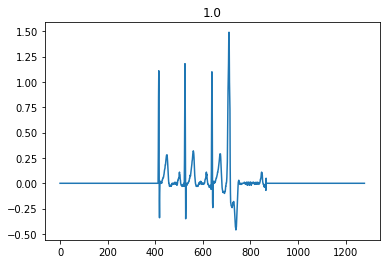

In [0]:
i=random.randint(0, len(all_in_data)-1 )
print(str(i)+'\t'+str(all_in_data[i][0:6]))
plt.plot(all_in_data[i][6:])
plt.title(str(all_in_data[i][1]))

# Perform Global Training

TEMP + MORPH

In [0]:
#Select global model name to save to
global_model_name = 'g3gmodel'
if global_model_name == '':
    global_model_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S%f')
global_model_name = 'G_' + global_model_name + '.h5'
global_model_path = os.path.join(global_modeldir,global_model_name)

print('Start Training Global Model  '+ global_model_name)
print( datetime.datetime.now() )
print ('use dataset '+ sel_set)
# Work the model.............................................

#def get_shaped_data(d_train, time_steps):
ds_xm, ds_xt, ds_y = get_shaped_data (all_in_data,timesteps)

model = getRNN(True)
print(model.summary())
history = model.fit(
                    [ds_xm, ds_xt], ds_y, 
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)



model.save_weights(global_model_path)   #save this model - GRNN0
print('\nSaved Global model @ '+str(global_model_path))

print('End Training Global Model  '+ global_model_name)
print( datetime.datetime.now() )

Start Training Global Model  G_g3gmodel.h5
2020-03-09 20:50:06.151584
use dataset GDS_b3b.npy
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_MORPH (InputLayer)           [(None, 1280, 1)]    0                                            
__________________________________________________________________________________________________
LSTM_50 (LSTM)                  (None, 1280, 50)     10400       IN_MORPH[0][0]                   
__________________________________________________________________________________________________
IN_TEMPO (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
LSTM_150 (LSTM)   

MOPRH (NO TEMP)

In [0]:
#Select global model name to save to
global_model_name = 'g3gmodel'
if global_model_name == '':
    global_model_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S%f')
global_model_name = 'GM_' + global_model_name + '.h5'
global_model_path = os.path.join(global_modeldir,global_model_name)

print('Start Training Global Model  '+ global_model_name)
print( datetime.datetime.now() )
print ('use dataset '+ sel_set)
# Work the model.............................................

#def get_shaped_data(d_train, time_steps):
ds_xm, ds_xt, ds_y = get_shaped_data (all_in_data,timesteps)

model = getRNN_notemp(True)
print(model.summary())
history = model.fit(
                    ds_xm, ds_y, 
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)



model.save_weights(global_model_path)   #save this model - GRNN0
print('\nSaved Global model @ '+str(global_model_path))

print('End Training Global Model  '+ global_model_name)
print( datetime.datetime.now() )

Start Training Global Model  GM_g3gmodel.h5
2020-03-10 19:32:59.416827
use dataset GDS_b3b.npy
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN_MORPH (InputLayer)        [(None, 1280, 1)]         0         
_________________________________________________________________
LSTM_50 (LSTM)               (None, 1280, 50)          10400     
_________________________________________________________________
LSTM_150 (LSTM)              (None, 150)               120600    
_________________________________________________________________
DENSE_M (Dense)              (None, 20)                3020      
_________________________________________________________________
DENSE_F (Dense)              (None, 10)                210       
_________________________________________________________________
OUTPUT_FC (Dense)            (None, 2)                 22        
Total params: 134,252
Trainab

# Perform Transfer Learning

After Local Training - model can perform better classification of Normal beats of that patient - this is becuase the model is 'transfer learning' only on well represented Normal beats from that patient. Also note that the amount of training data is too low in transfer learning (50) - this directly effects the 'fitting' of local data and may overfit if large number of normal beats are trained upon. This model will always have the tendency to classify every thing as normal because it has only seen normal beats during transfer learning.

NOTE:

In global model - more beats will be predicted as Abnormal than actual are - but its sensetivity of abnormal beats is high - meaning less Abnormal beats will be left out from classifying correctly. Hence global model may give more false positives for Abnormal Beats - its ok - the global model also detects normal beats adjoining an abnormal beat and classify them as abnormal too.

Take a Beat and classify it using both model - 

if both models agree to same type then its ok

otherwise, 

take descision with greater confidence



In [0]:
# Select a global model to perform transfer learning on...
#  list available models on disk to choose a from
dbfiles = os.listdir(global_modeldir)
for i in dbfiles:
    print(i)

G_GM_TEST_01.h5
L_LM_TEST.h5
G_g3gmodel.h5
L_g3gmodel.h5


TEMP + MORPH

In [0]:
#Select Global model to transfer from
global_model_name = 'G_g3gmodel'
global_model_path = os.path.join(global_modeldir,global_model_name+'.h5')

#Select local model name to save to
local_model_name = 'g3gmodel'
if local_model_name == '':
    local_model_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S%f')
local_model_name = 'L_' + local_model_name + '.h5'
local_model_path = os.path.join(global_modeldir,local_model_name)



#........................................................................................
#........................................................................................
# Work the model.............................................
print('Transfer Learning :: '+ global_model_name + ' --> '+ local_model_name )
print( datetime.datetime.now() )
print ('use dataset '+ sel_set)
modeltest = getRNN(False)
modeltest.load_weights(global_model_path) 
print(modeltest.summary())

ds_xm, ds_xt, ds_y = get_shaped_data (all_in_data[0:2000],timesteps)
history = modeltest.fit(
                    [ds_xm,ds_xt], ds_y, 
                    #batch_size=1000,
                    epochs=5,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

#........................................................................................
modeltest.save_weights(local_model_path) 
print('\nSaved Local model @ '+str(local_model_path))
print('Transfer Learning End' )
print( datetime.datetime.now() )

Transfer Learning :: G_g3gmodel --> L_g3gmodel.h5
2020-03-10 17:31:15.246489
use dataset mitdb_208_LOCAL.npy
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_MORPH (InputLayer)           [(None, 1280, 1)]    0                                            
__________________________________________________________________________________________________
LSTM_50 (LSTM)                  (None, 1280, 50)     10400       IN_MORPH[0][0]                   
__________________________________________________________________________________________________
IN_TEMPO (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
LSTM_150 (LSTM)                 (None, 150)          120600      LSTM_50[0][0]   

MORPH (NO TEMP)

In [0]:
#Select Global model to transfer from
global_model_name = 'G_g3gmodel'
global_model_path = os.path.join(global_modeldir,global_model_name+'.h5')

#Select local model name to save to
local_model_name = 'g3gmodel'
if local_model_name == '':
    local_model_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S%f')
local_model_name = 'LM_' + local_model_name + '.h5'
local_model_path = os.path.join(global_modeldir,local_model_name)



#........................................................................................
#........................................................................................
# Work the model.............................................
print('Transfer Learning :: '+ global_model_name + ' --> '+ local_model_name )
print( datetime.datetime.now() )
print ('use dataset '+ sel_set)
modeltest = getRNN_notemp(False)
modeltest.load_weights(global_model_path) 
print(modeltest.summary())

ds_xm, ds_xt, ds_y = get_shaped_data (all_in_data[0:2000],timesteps)
history = modeltest.fit(
                    ds_xm, ds_y, 
                    #batch_size=1000,
                    epochs=5,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

#........................................................................................
modeltest.save_weights(local_model_path) 
print('\nSaved Local model @ '+str(local_model_path))
print('Transfer Learning End' )
print( datetime.datetime.now() )

PREDICT DATA

# Predict Loaded Data

List avaiable models

In [0]:
# choose global and local model weights beforehand
dbfiles = os.listdir(global_modeldir)
#print(dbfiles)
for i in dbfiles:
    print(i)

G_GM_TEST_01.h5
L_LM_TEST.h5
G_g3gmodel.h5
L_g3gmodel.h5


All testing below uses variable 'model_p'

Make sure to load appropiate model in 'model_p' and appropiate data in 'all_in_data'

In [0]:
global_model_name = 'G_g3gmodel'
local_model_name = 'L_g3gmodel'
# ----------------------------------------------------------------------
global_model_path = os.path.join(global_modeldir,global_model_name+'.h5')
local_model_path = os.path.join(global_modeldir,local_model_name+'.h5')
#print ("MODEL:\t" + str(model_path))
# ----------------------------------------------------------------------
model_global = getRNN(False)
model_global.load_weights(global_model_path)

model_local = getRNN(False)
model_local.load_weights(local_model_path)

print(model_global.summary())

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_MORPH (InputLayer)           [(None, 1280, 1)]    0                                            
__________________________________________________________________________________________________
LSTM_50 (LSTM)                  (None, 1280, 50)     10400       IN_MORPH[0][0]                   
__________________________________________________________________________________________________
IN_TEMPO (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
LSTM_150 (LSTM)                 (None, 150)          120600      LSTM_50[0][0]                    
___________________________________________________________________________________________

Predict using Loaded Model and DataSet

In [0]:
print ('current dataset '+ sel_set)

current dataset mitdb_208_ALL.npy


In [0]:
# Make sure to load data in 'all_in_data'



ds_xm, ds_xt, ds_y = get_shaped_data (all_in_data,timesteps)
#......................................................................
print ('Predict on dataset '+ sel_set + ' using model ' + global_model_name)
rnn_pred_global = model_global.predict( [ds_xm,ds_xt]) # array of  samples x classes(4) - each row is a prediction of sample
cmx_global = np.zeros((g_COUNT,g_COUNT),dtype='int32')
cmx2_global = rnn_pred_global.argmax(axis=1)
for i in range(0,len(cmx2_global)):
    alabel = int(alld_l[i])
    plabel = cmx2_global[i]
    cmx_global[alabel,plabel]+=1
print('\tConfusion Matrix')
print(print_conf_matrix(cmx_global,'')) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_global) ) 

print('')
#......................................................................
print ('Predict on dataset '+ sel_set + ' using model ' + local_model_name)
rnn_pred_local = model_local.predict( [alld_m.reshape((dlen,timesteps,1)),alld_t]) # array of  samples x classes(4) - each row is a prediction of sample
cmx_local = np.zeros((g_COUNT,g_COUNT),dtype='int32')
cmx2_local = rnn_pred_local.argmax(axis=1)
for i in range(0,len(cmx2_local)):
    alabel = int(alld_l[i])
    plabel = cmx2_local[i]
    cmx_local[alabel,plabel]+=1
print('\tConfusion Matrix')
print(print_conf_matrix(cmx_local,'')) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_local) ) 

Predict on dataset mitdb_208_ALL.npy using model G_g3gmodel
	Confusion Matrix
A\P	N	A
N	192	50
A	338	2371

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.87	0.36	0.79	0.88
A	0.87	0.98	0.88	0.79

Predict on dataset mitdb_208_ALL.npy using model L_g3gmodel
	Confusion Matrix
A\P	N	A
N	149	93
A	170	2539

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.91	0.47	0.62	0.94
A	0.91	0.96	0.94	0.62


# View a Prediction

Works only when the whole record was used in prediction ( continuation of above cell )

mitdb_208 Duration = 180 sec  [1500:1680]


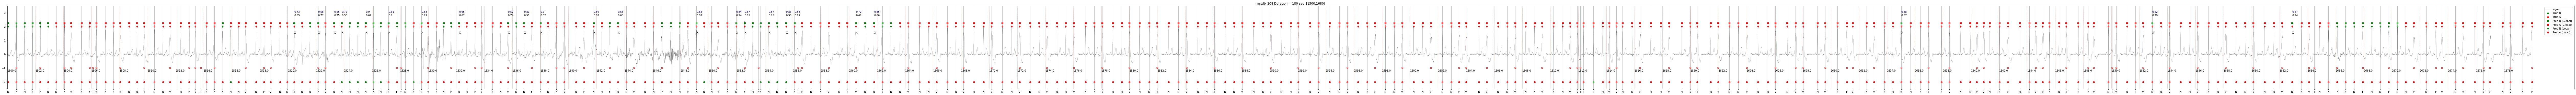

In [0]:
plot_predictions = True# False True

# Select a record that was predited ( prediction results in d_train )
test_rec=all_db['mitdb'].get_record('208')

# calculate limits
fs = 1500
ts = fs+180
ds= ts-fs
ff=fs*test_rec.db.srate
tt=ts*test_rec.db.srate
ptitle = test_rec.name+' Duration = '+ str(ds) + ' sec  ['+str(fs)+':'+str(ts) + ']'
print(ptitle)
# plot actual ecg signal
sigX = np.multiply(test_rec.read_data(g_MED2_POSTFIX)[ff:tt],[1/test_rec.gain])
plt.figure(0, figsize=((ds*(60/60)),6))
plt.xlim(0, len(sigX)+3*test_rec.db.srate)
plt.ylim(-2.5,3.5)
plt.plot(sigX, linewidth=0.2, color='black', label='signal')

# plot orignal Annotations
a0 = test_rec.read_data(g_ANT_POSTFIX)
a0_pk = a0[:,0].astype('int')
a1 = a0[(a0_pk>=ff) & (a0_pk<tt)]
a1x = np.subtract(a1[:,0].astype('int'),[ff])
a1y = a1[:,1]
#a1z = np.multiply(a1[:,0].astype('int') , [1/test_rec.db.srate])

a1xx = a1x[a1y!='N']
plt.scatter(a1xx,np.subtract(np.zeros(len(a1xx)),[1]), color='red',marker='x') #plt.scatter(a1x,a1y)

atsecX = np.arange(0,len(sigX),2*test_rec.db.srate) #<---------------------------------multiply for each second
#atsecY = np.multiply(np.arange(ff,tt,test_rec.db.srate),[1/test_rec.db.srate] )
for i in range(0,len(atsecX)):
    plt.annotate( str(round((atsecX[i]+ff)/test_rec.db.srate,2)), xy=(atsecX[i],-1.25))
    plt.vlines(atsecX[i], -2.5,3.5, linewidth=0.5, linestyles='dotted', color='red' )

#plt.xticks(np.arange(0,len(sigX),test_rec.db.srate), np.multiply(np.arange(ff,tt,test_rec.db.srate),[1/test_rec.db.srate] ))
plt.xticks(a1x,a1y)

plt.grid(axis='x')

if plot_predictions:
    # use params from previous cell * Use alld_m to plot actual downsampled ecg signals used by Model in training
    allpeak = d_train[:,0].astype('int')
    sidx = np.arange(0,len(allpeak),1)
    speak = allpeak[sidx[(allpeak>=ff) & (allpeak<tt)]]
    slab = alld_l[sidx[(allpeak>=ff) & (allpeak<tt)]]
    #ssig = alld_m[sidx[(allpeak>=ff) & (allpeak<tt)]]
    sfpeaks = np.subtract(speak,[ff])

    # Scatter plot Ground Truth Labels
    slabint = slab.astype('int') #g_LABELS[slab.astype('int')]  plt.xticks(sfpeaks,slabint)
    zi = sfpeaks[slabint==0]
    plt.scatter(zi,np.subtract(np.zeros(len(zi)),[2]),color = 'green', marker='o', label = 'True N')
    zi = sfpeaks[slabint!=0]
    plt.scatter(zi,np.subtract(np.zeros(len(zi)),[2]),color = 'red', marker='o', label = 'True A')

    # Scatter plot Predicted Labels
    # _global _local
    scmx_global = cmx2_global[sidx[(allpeak>=ff) & (allpeak<tt)]]
    spred_global =rnn_pred_global[sidx[(allpeak>=ff) & (allpeak<tt)]]
    zi = sfpeaks[scmx_global==0]
    plt.scatter(zi,np.add(np.zeros(len(zi)),[2.25]),color = 'green', marker='s', label = 'Pred N (Global)')
    zi = sfpeaks[scmx_global!=0]
    plt.scatter(zi,np.add(np.zeros(len(zi)),[2.25]),color = 'red', marker='s', label = 'Pred A (Global)')

    scmx_local = cmx2_local[sidx[(allpeak>=ff) & (allpeak<tt)]]
    spred_local =rnn_pred_local[sidx[(allpeak>=ff) & (allpeak<tt)]]
    zi = sfpeaks[scmx_local==0]
    plt.scatter(zi,np.add(np.zeros(len(zi)),[2]),color = 'green', marker='d', label = 'Pred N (Local)')
    zi = sfpeaks[scmx_local!=0]
    plt.scatter(zi,np.add(np.zeros(len(zi)),[2]),color = 'red', marker='d', label = 'Pred A (Local)')

    # plot prediction probability
    #plt.scatter(sfpeaks,spred[:,0], color='green')
    #plt.scatter(sfpeaks,spred[:,1], color='red')
    plt.annotate('Global',xy=(-100,2),color='blue')
    plt.annotate('Local',xy=(-100,1.75),color='black')
    for i in range (0, len(scmx_global)):
        if scmx_global[i]!=scmx_local[i]:
            plt.annotate('X', xy=(sfpeaks[i],1.5))

            g_conf = round( spred_global[i][scmx_global[i]] , 2)
            l_conf = round( spred_local[i][scmx_local[i]] , 2)
            plt.annotate(str(g_conf), xy=(sfpeaks[i],3), color='navy')
            plt.annotate(str(l_conf), xy=(sfpeaks[i],2.75),color='black')

else:
    print('No predictions were plotted')
plt.title(ptitle)
plt.legend()

In [0]:
for ind in range (0,len(cmx2_global)):
    if cmx2_global[ind]!=cmx2_local[ind]:
        print('Global: \t'+str(rnn_pred_global[ind]) + '\t'+ str(cmx2_global[ind]) + '\t'+ 'Local: \t'+str(rnn_pred_local[ind]) + '\t'+ str(cmx2_local[ind]))
    #print('Local: \t'+str(rnn_pred_local[ind]) + '\t'+ str(cmx2_local[ind]))

# ALL RECORDS Prediction

In [0]:


# 1 select random database
rand_db = ['mitdb' , 'svdb', 'incartdb']



#beats_info=selrec.load_data('ant_m2')
#beats_taken = np.zeros((0,binfo_props),dtype='U10')
#savepath = os.path.join( global_datadir, selrec.name + '_All.npy')
#print(len(beats_info))
#print(beats_info)
#np.save(savepath,beats_info)


z_len = 4
for idbs in rand_db:
    dbs = all_db[idbs]
    reclist = list(dbs.recs)    # is a list of strings
    for irec in reclist:
        selrec = dbs.get_record(irec) # is an 'ecg_record' objec
        print(selrec.name)
        srate = selrec.db.srate


        #1 LOAD mapped anootation file
        in_data = selrec.read_data('ant_m2')
        data_count = len(in_data)

        #2 Extract Signal
        all_in_data= np.zeros((0,timesteps+z_len))

        for i in range(0,data_count):
            ib = in_data[i]
            if int(ib[6]) < 0:
                print('Found unmapped beat - cant use in evaluation...'+ str(ib))
                continue
            
            sigval, peak, label, len_arr, len_time, RRp, RRn = get_signal( ib, all_db, True, 3, True)
            if len(sigval)<10:
                print('WARNING: Signal window too low '+str(sigval))
            siglen = len(sigval)
            sigval = np.hstack(( sigval, np.zeros(timesteps-siglen) ))
            tdata = np.array( [int(ib[3]), int(ib[6]), peak, len_arr-peak], dtype ='float')
            all_in_data = np.vstack( (all_in_data, np.hstack( (tdata , sigval ) )   ) )

        print((all_in_data.shape))
        
        #3 Ready to predict...
        d_train = all_in_data
        # timesteps
        dlen = len(d_train)
        alld_l = d_train[:,1]
        alld_t = d_train[:,2:4]
        alld_m = d_train[:,4:]
        rnn_pred = model_p.predict( [alld_m.reshape((dlen,timesteps,1)),alld_t]) # array of  samples x classes(4) - each row is a prediction of sample

        #4 print results...
        cmx = np.zeros((g_COUNT,g_COUNT),dtype='int32')
        cmx2 = rnn_pred.argmax(axis=1)
        for i in range(0,len(cmx2)):
            alabel = int(alld_l[i])
            plabel = cmx2[i]
            cmx[alabel,plabel]+=1
        print('Confusion Matrix')
        print(print_conf_matrix(cmx,'')) #logit('\t'+str(cmx))
        print_performance( get_performance(cmx) ) 
        # now calculate entory and difference index and save it
        print('==============================================')

# --- ARCHIVE ---

In [0]:
# Hear rate params
H_min = 30
H_low = 60
H_hig = 100
H_max = 200

beat_win_min = 60 / H_min  #seconds
#base_png_dir = '/content/drive/My Drive/Masters/workdir/ecg_data/db_npy/data_png/'

# 1 select random database
randdb = ['mitdb' , 'svdb', 'incartdb']
idbs = randdb[random.randint(0,2)]#'mitdb'  # 'mitdb'  'svdb' 'incartdb'
dbs = all_db[idbs]

# 2 select random record
reclist = list(dbs.recs)
irec = reclist[random.randint(0,len(reclist)-1)] #'219'
selrec = dbs.get_record(irec)
print('selected record ' + str(selrec.name))

# 3 read record data and params
manual_gain=1/selrec.gain
srate = selrec.db.srate
selrec.load_data(g_ANT_POSTFIX)   
selrec.load_data(g_MED5_POSTFIX)
selrec.load_data(g_MED2_POSTFIX)
# 6 extract signals ==================================================================================
med2 = selrec.read_data(g_MED2_POSTFIX)
med5 = selrec.read_data(g_MED5_POSTFIX)
meds = [med2, med5]
L = len(med2)
Lsec = L / srate # total record length in seconds ~ 1800 secs

# 4 Data View Parameters
v_cutoff = beat_win_min #  = 2 sec NOTE: any beat within this interval from either side of the view is not considered a beat
v_dur = 60 #random.randint(20,30) #v_to - v_fo # sec random duration of 10 to 20 secs
v_fo = random.randint(v_cutoff,int(Lsec)-v_dur) #300 # sec

v_to = v_fo + v_dur # sec
# calculate time -> samples
fii = int(v_fo*srate) # sample
tii = int(v_to*srate) # sample
dii = tii-fii  # samples
cii = int(v_cutoff*srate)  # samples

# 5 extract annotations ==================================================================================
ant2 = selrec.read_data(g_ANT_POSTFIX)       # all annotations
ant_s = ant2[:,0].astype('int')
#ant_l = ant2[:,1]

ant2x = ant2[(ant_s>=fii) & (ant_s<tii)]    # within range annotations
ant_slx =  np.subtract(ant2x[:,0].astype('int'), [fii])
#print(ant2x)
ant_lx = ant2x[:,1]
ant_mx = mapstd(ant_lx)
ant2m = ant2x[ant_mx>-2]        # -1 ,0 .... are beat labels -1 being unmapped R peak
ant_sx = ant2m[:,0].astype('int')
ant_sy = ant2m[:,1]
ant2x_dict ={}                              # dictionary of annotation cound
for mk in range(0,len(ant_lx)):
    if ant_lx[mk] in ant2x_dict:
        ant2x_dict[ant_lx[mk]]+=1
    else:
        ant2x_dict[ant_lx[mk]]=1
print(selrec.name + ' [Duration] = '+ str(v_fo)+':'+str(v_to)+' = '+ str(v_dur) + ' sec')
print(str(ant2x_dict))



# for Pan-Tompkins QRS detector
detectors = Detectors(srate)
hrva = hrv.HRV(srate)
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================
#=================================================


#==================================================================================


# calculate padding on both sides
ri_f = 0
ri_t = 0
if fii<0:
    ri_f = -fii
    fii = 0
if tii>L:
    ri_t =  tii - L 
    tii=L



#med2X = np.arange(fi,ti,1/selrec.db.srate)




ff = 0 #figure
#print(' '+ str())

    
    # read r peaks from annotation
r_peaks = np.subtract(ant_sx, [fii])
r_peaks_N =  ant_slx[ant_mx==2]
#r_peaks_B =  ant_slx[ant_mx==1]
#r_peaks_A =  ant_slx[ant_mx==2]
#print (r_peaks)
    # ... otherwise the detected peaks
#r_peaks = detectors.pan_tompkins_detector(unfiltered_ecg = imed)
#r_peaks = detectors.hamilton_detector(unfiltered_ecg = imed)
#r_peaks = detectors.christov_detector(unfiltered_ecg = imed)
#r_peaks = detectors.engzee_detector(unfiltered_ecg = imed) #doesnt work for lead5 - no peaks detected
#r_peaks = detectors.swt_detector(unfiltered_ecg = imed)
#r_peaks = detectors.two_average_detector(unfiltered_ecg = imed)

r_peaks = np.array(r_peaks)
rr_samples = r_peaks[(r_peaks >= cii) & (r_peaks < dii - cii)] # cutoff peaks
rr_samples_N = r_peaks_N[(r_peaks_N >= cii) & (r_peaks_N < dii - cii)] # cutoff peaks
#calculate Rate and RR Interval array
nos_peaks = len(rr_samples)
heart_rate = hrva.HR(rr_samples)
RRi = np.zeros(nos_peaks-1,dtype = 'float')
for i in range(0,nos_peaks-1):
    RRi[i]=(rr_samples[i+1]-rr_samples[i])/srate


man_heart_rate = (nos_peaks*60)/(v_dur-2*v_cutoff)
avg_heart_rate = np.average(heart_rate)
avg_rri = np.average(RRi)
rri_hear_rate = (60/avg_rri)
final_hear_rate = (man_heart_rate+avg_heart_rate+rri_hear_rate)/3

print('Nos peaks '+ str(nos_peaks))
print('Avergae RR Interval\t'+ str(avg_rri))
print('\nManual Heart rate\t'+ str(man_heart_rate))
print('Avergae Heart rate\t'+ str(avg_heart_rate))
print('Avergae RRi Rate\t'+ str(rri_hear_rate))
print('Final Heart Rate\t'+ str(final_hear_rate))



beat_window = (60/final_hear_rate)  * 0.85
print('Beat Window\t'+ str(beat_window))

beat_window_s = int(beat_window*srate) #samples
# if odd make it even
#if beat_window_s % 2 != 0:
#    beat_window_s+=1
plt.figure(ff, dpi=100)
ff+=1
#print('RRi Array\n'+str(RRi))
plt.ylabel('RRi (sec)')
plt.ylim(0, 3) # secs
plt.xlim(0, len(RRi))
plt.plot(RRi)
plt.hlines((60/H_low),0,len(RRi),linewidth=0.2, color='green')
plt.hlines((60/H_hig),0,len(RRi),linewidth=0.2, color='green')

#Calculate heart-rates from R peak samples.
print('Nos RRis '+str(len(heart_rate)))

plt.figure(ff, dpi=100)
ff+=1
aa = plt.axes()
ax = aa.get_xaxis()
ay = aa.get_yaxis()
ay.set_major_locator(ticker.MultipleLocator(20))
#print('RRi Array\n'+str(RRi))
plt.ylabel('Heart Rate (bpm)')
plt.ylim(H_min-20, H_max+10) #bpm
plt.xlim(0, len(heart_rate))
plt.plot(heart_rate)
plt.grid(axis='y')


#plt.figure(ff, dpi=100)
#ff+=1
#aa = plt.axes()
#ax = aa.get_xaxis()
#ay = aa.get_yaxis()
#ay.set_major_locator(ticker.MultipleLocator(20))
#print('RRi Array\n'+str(RRi))
#plt.ylabel('Heart Rate (bpm)')
#plt.ylim(H_min-20, H_max+10) #bpm
#plt.xlim(0, len(heart_rate))
#plt.plot(heart_rate)
#plt.grid(axis='y')


#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


#print('Calculate heart-rates from R peak samples. '+ str(heart_rate))

#h_NN20 = hrva.NN20( rr_samples)
#print('Calculate NN20, the number of pairs of successive NNs that differ by more than 20 ms. '+ str(h_NN20))
#Calculate NN20, the number of pairs of successive
#NNs that differ by more than 20 ms.

#h_NN50 = hrva.NN50( rr_samples)
#print('Calculate NN50, the number of pairs of successive NNs that differ by more than 50 ms. '+ str(h_NN50))
#Calculate NN50, the number of pairs of successive
#NNs that differ by more than 50 ms.

#h_RMSD = hrva.RMSSD( rr_samples, normalise=False)
#print('Calculate RMSSD (root mean square of successive differences). '+ str(h_RMSD))
#Calculate RMSSD (root mean square of successive differences).

#h_SD = hrva.SDANN( rr_samples, average_period=5.0, normalise=False)
#print('Calculate SDANN, the standard deviation of the average '+ str(h_SD))
#Calculate SDANN, the standard deviation of the average
#RR intervals calculated over short periods.

h_SDNN = hrva.SDNN( rr_samples, normalise=False)
print('Calculate SDNN, the standard deviation of NN intervals. '+ str(h_SDNN))
#Calculate SDNN, the standard deviation of NN intervals.


h_SDSD = hrva.SDSD( rr_samples)
print('Calculate the standard deviation of the successive differences between adjacent NNs. '+ str(h_SDSD))
#Calculate SDSD (standard deviation of successive differences),
#the standard deviation of the successive differences between adjacent NNs.

h_fs = hrva.fAnalysis( rr_samples)
print('returns the LF/HF-ratio. '+ str(h_fs))
print(hrva.lf)
print(hrva.hf)
#Frequency analysis to calc self.lf, self.hf,
#returns the LF/HF-ratio.

#h_pNN20 = hrva.pNN20( rr_samples)
#print('Calculate pNN20, the proportion of NN20 divided by total number of NNs. '+ str(h_pNN20))
#Calculate pNN20, the proportion of NN20 divided by total number of NNs.

#h_pNN50 = hrva.pNN50( rr_samples)
#print('Calculate pNN50, the proportion of NN50 divided by total number of NNs. '+ str(h_pNN50))
#Calculate pNN50, the proportion of NN50 divided by total number of NNs.
    # perpare figure - MEDIAN BEAT ======================================


stats_dict={}
stats_dict['mean'] = stats.mean(RRi)
#stats_dict['geometric_mean'] = stats.geometric_mean(RRi)
#stats_dict['harmonic_mean'] = stats.harmonic_mean(RRi)
stats_dict['median'] = stats.median(RRi)
stats_dict['median_low'] = stats.median_low(RRi)
stats_dict['median_high'] = stats.median_high(RRi)
stats_dict['median_grouped'] = stats.median_grouped(RRi)

try_mode = 0
try:
  try_mode = stats.mode(RRi)
except:
  print("Cant find mode...")
else:
  stats_dict['mode'] = try_mode
  print("found mode = "+ str(try_mode))

stats_dict['pstdev'] = stats.pstdev(RRi)
stats_dict['pvariance'] = stats.pvariance(RRi)
stats_dict['stdev'] = stats.stdev(RRi,stats_dict['median'])
stats_dict['variance'] = stats.variance(RRi,stats_dict['median'])
#print('Stats')
print_dict('stats',stats_dict, '\t')


for mx in range (0,len(meds)):
    print('========= LEAD '+ str(mx))
    imed = meds[mx][fii:tii] # the signal
    imed = np.multiply(imed, [manual_gain]) # normalized signal    
    #beat_sides = int((beat_window_s)*2)  # surely divisible
    # for each rr_samples take beat_sides from either side
    plt.figure(ff,  figsize=( 4*(beat_window_s *2 +1)/srate, 8 )  ,dpi=100)
    ff+=1
    plt.ylim( -3.5, 3.5 )  # mv
    plt.xlim( 0 , beat_window_s *2 +1 )   # 

    beat_dict = np.zeros((0,beat_window_s*2),dtype = 'float')
    #print(beat_window_s*2)
    for rrs in range(0,len(rr_samples_N)):
        peak_at = rr_samples_N[rrs]
        rfo = peak_at-beat_window_s
        rto = peak_at+beat_window_s
        beat_i = imed[rfo:rto]
        #print(len(beat_i))
        plt.plot(beat_i, label = str(rrs), linewidth=0.2, color='black')
        beat_dict = np.vstack((beat_dict,beat_i))
    print('Beat Dict: '+ str(beat_dict.shape))
    print(beat_dict) #<---------------------------------------------------------------Got all beats here - cluster them
    row = beat_dict.shape[0]  # nos of rows (data points / vectors)
    col = beat_dict.shape[1]  # nos of coloumns (dimensions)

    med_beat = np.zeros(col)
    mean_beat = np.zeros(col)
    for coli in range(0,col): # for all coulumns find median
        med_beat[coli] = stats.median(beat_dict[:,coli])
        mean_beat[coli] = stats.mean(beat_dict[:,coli])
    plt.plot(med_beat)
    plt.plot(mean_beat)


    # perpare figure ======================================
    plt.figure(ff, figsize=( dii/srate, 8 )  ,dpi=50)
    ff+=1
    plt.ylim( -3.5, 3.5 )  # mv
    plt.xlim( 0 , dii  )   # 
    aa = plt.axes()
    ax = aa.get_xaxis()
    ay = aa.get_yaxis()
    #ax.set_major_locator(ticker.MultipleLocator(srate))
    ay.set_visible(False)
    plt.grid(axis='x')
    plt.xticks(ant_slx,ant_lx)
    plt.plot(imed,linewidth='0.2', color='black')
    plt.plot( np.arange(0, cii, 1), imed[0:cii],linewidth='0.5', color='red')
    plt.plot( np.arange(dii-cii, dii, 1), imed[dii-cii:dii]  ,linewidth='0.5', color='red')
    plt.scatter(rr_samples, np.ones(len(rr_samples)),color='red',marker='x')
    #plt.scatter(max_peaks, np.zeros(len(max_peaks)),color='blue',marker='.')
    


# TO DO :: NEXT find DISSIMILARITY MEASURE and CLUSTER beats locally within a stable range of RRi

# in the whole record find parts where RRIntervals remain constant and treat those as representing on cluster - cluster them

In [0]:
# DONT RUN THIS 

rand_db = ['mitdb' , 'svdb', 'incartdb']
print('DB_RECORD\tALL\t*N*\t*A*\t*X*\tSNN\tSAA\tRRI')
for idbs in rand_db:
    
#idbs = rand_db[random.randint(0,2)]
    #print(idbs)
    dbs = all_db[idbs]

    # 2 select random record
    reclist = list(dbs.recs)    # is a list of strings
    
    for irec in reclist:
        #irec = reclist[random.randint(0,len(reclist)-1)]  # should be a string
        #print(irec)
        selrec = dbs.get_record(irec) # is an 'ecg_record' object
        #print('selected record ' + str(selrec.name))
        srate = selrec.db.srate
        #beat_cutoff_window = int(beat_cut_time*srate) #2 sec

        
        beats_info=selrec.load_data('ant_m2')
        rr_samples =  beats_info[:,3].astype('int') # beats_info[:,3].astype('int')  # 3 for location of peak sample
        nos_peaks = len(rr_samples)
        #print('*[*]* beats\t'+ str(nos_peaks))

        #binfo_props = 
        #len(['0_db', '1_rec', '2_begin', '3_peak', '4_end', '5_label', '6_int_label', '7_is_3N', '8_prev_RRi', '9_next_RRi','10_delta_RRi'])

        # For Normal beats select only those which are surronded by 2 other normal beats and
        # have the succesive rri difference almost same (within his_resolution range)
        succ_rri_for_N = 0.05 #if differnece in succesvie rri are more than this then its not normal
        succ_rri = np.multiply(beats_info[:,10].astype('int'),[1/ srate])

        #beats_info_NNN = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='0')]
        beats_info_N = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='0') & (succ_rri <= succ_rri_for_N)] #<----- THIS IS N
        #beats_info_Nd = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='0') & (succ_rri > succ_rri_for_N)]
        #beats_info_NAd = beats_info[(beats_info[:,7]=='1') & (beats_info[:,6]=='0')]
        beats_info_anyN =  beats_info[(beats_info[:,6]=='0')]
        # for Abnormal beats select all abnormal
        beats_info_A = beats_info[(beats_info[:,6]=='1')] #<------ THIS IS A
        beats_info_X = beats_info[(beats_info[:,6]=='-1')]

        #print('*[N]* beats\t'+ str(beats_info_anyN.shape))
        #print('*[A]* beats\t'+ str(beats_info_A.shape))#<------ THIS IS A
        #print('*[X]* beats\t'+ str(beats_info_X.shape))
        #print('')
        #print('Sel N beats\t'+ str(beats_info_N.shape)) #<----- THIS IS N
        #print('Sel A beats\t'+ str(beats_info_A.shape))#<------ THIS IS A
        
        #print('N[N]N beats: '+ str(beats_info_NNN.shape))
        #print('N[N]N beats <=succ_rri: '+ str(beats_info_N.shape)) #<----- THIS IS N
        #print('N[N]N beats >succ_rri '+ str(beats_info_Nd.shape))
        #print('A[N]A N[N]A A[N]N beats: '+ str(beats_info_NAd.shape))
        RRi = (beats_info[:,8].astype('int')+beats_info[:,9].astype('int'))/(2*srate)
        sRRi = (beats_info[:,10].astype('int'))/(srate)

        avg_RRi = np.average(RRi)
        #print('Avergae RRi\t'+ str(avg_RRi)+ ' sec')
        #print('Heart Rate\t'+ str(hear_rate)+ ' bpm')
        print(str(selrec.name)+'\t'+ str(nos_peaks)+'\t'+str(beats_info_anyN.shape[0])+'\t'+str(beats_info_A.shape[0])+
              '\t'+str(beats_info_X.shape[0])+'\t'+str(beats_info_N.shape[0])+'\t'+str(beats_info_A.shape[0])+'\t'+str(avg_RRi))


#        pad_time = 0.1 #sec
#        plt.figure(0,figsize=(nos_peaks/50,8), dpi=80) # <------------------------------------- RRi
#        aa = plt.axes()
#        ax = aa.get_xaxis()
#        ay = aa.get_yaxis()
#        ay.set_major_locator(ticker.MultipleLocator(0.2))
#        plt.ylim(-pad_time-min_rri, min_rri+pad_time )
#        plt.xlim(0,nos_peaks)
#        plt.ylabel('Time (sec)')
#        plt.plot(RRi,linewidth=0.8,color = 'black', label = 'RRi')
#        plt.plot(sRRi*-1,linewidth=0.4,color = 'red', label = 'sRRi')
#        plt.hlines( low_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='green' )
#        plt.hlines( hig_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='green' )
#        plt.hlines( max_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='red' )
#        plt.hlines( min_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='red' )
#        plt.hlines( avg_RRi,0,nos_peaks,linestyles='dotted', linewidth=1, color='blue' )
#        plt.hlines( -succ_rri_for_N,0,nos_peaks,linestyles='dotted', linewidth=1, color='black' )
#
#        #plt.hlines( hist_resolution,0,nos_peaks,linestyles='dotted', linewidth=0.5, color='black' )
#        plt.title(str(selrec.name))
#        #plt.grid(axis='y')
#        plt.legend()
#        savepath = os.path.join( global_datadir, selrec.name+'.png')
#        plt.savefig( savepath,bbox_inches='tight')
#        plt.close()

In [0]:
#ORIGNAL
#get_signal




# 1 select random database
rand_db = ['mitdb' , 'svdb', 'incartdb']
idbs = rand_db[random.randint(0,2)]
dbs = all_db[idbs]
print(idbs)


# 2 select random record
reclist = list(dbs.recs)    # is a list of strings
irec = reclist[random.randint(0,len(reclist)-1)]  # should be a string
print(irec)
selrec = dbs.get_record(irec) # is an 'ecg_record' object
print('selected record ' + str(selrec.name))
srate = selrec.db.srate
beat_cutoff_window = int(beat_cut_time*srate) #2 sec


# 3 locate beats and non-beat annotations(RR-peaks)=========================================================================
#   use mapstd(labels) : beat annotations map to 
ant2 = selrec.load_data(g_ANT_POSTFIX)      # annotation data
antm = mapstd(ant2[:,1])                    # map annotations to integer label [-2, -1, 0, 1, 2, 3 ... ]
ant2_beats = ant2[antm>-2]                  # only RR peaks
ant2_nonbeats = ant2[antm<=-2]              # only non beats
# prepare an array of beat info for each record  this shall contain int lables
# binfo = [ 0=s_db,     1=s_rec,    2=s_being,  3=s_peak,   4=s_end,    5=s_label, 6=s_label_int, 7=tri_N ]
# how many beats are there = len(ants)-2   |excluding first and last peak
binfo_props = len(['0_db', '1_rec', '2_begin', '3_peak', '4_end', '5_label', '6_int_label', '7_is_3N', '8_prev_RRi', '9_next_RRi','10_delta_RRi'])


beats_info = np.zeros((0, binfo_props),dtype='U10')
for i in range(1, len(ant2_beats)-1): # exclude first and last beat
    ci = np.zeros(binfo_props,dtype='U10') 
    ci[0] = idbs            # db this beat belongs to
    ci[1] = irec            # record this beat belongs to

    RRp = int(ant2_beats[i-1,0])     # prev R peak
    RRi = int(ant2_beats[i,0])       # current R
    RRn = int(ant2_beats[i+1,0])     # next R peak


    # 8,9,10 are distance from prev and next R peak independend of beat_cutoff_window - #RRp RRn can change in windown fitting
    ci[8]=str(RRi - RRp)
    ci[9]=str(RRn - RRi)
    ci[10] = str(abs((RRi - RRp) - (RRn - RRi)))
    # chek if prev and next peaks are more than 2 secs
    delta_p = ( RRi - RRp )  # seconds
    delta_n = ( RRn - RRi ) 
    if delta_p > beat_cutoff_window : 
        RRp = RRi-beat_cutoff_window
        print ("PREV WINDOW overflow: db="+ idbs+ ' | rec='+ irec + '| peak='+ str(RRi)+ ' | Pwin='+str(delta_p/srate))
    if delta_n > beat_cutoff_window : 
        RRn = beat_cutoff_window+RRi
        print ("NEXT WINDOW overflow: db="+ idbs+ ' | rec='+ irec + '| peak='+ str(RRi)+ ' | Nwin='+str(delta_n/srate))

    ci[2] = str(RRp)
    ci[3] = str(RRi)
    ci[4] = str(RRn)
    
    ci[5] = ant2_beats[i,1]       # string label this contains beat annotations only
    ci[6] = str(g_MIT_AMAP[ant2_beats[i,1]])

    if g_MIT_AMAP[ant2_beats[i-1,1]] == 0 and g_MIT_AMAP[ant2_beats[i+1,1]] == 0:
        ci[7] = '0'  #  surronded by 2 normal 
    else:
        ci[7] = '1' # not surronded by 2 normal beats one or both may be abnormal

        # 6,7 =  0,0 means noraml surronded by 2 normal                 NN 0<---- not all only those who vary less in succ_rri
        #        0,1 means normal surronded by 1 or 2 abnormal          NA 1<------ we not selecting this for training
        #        1,0 means abnorm surronded by 2 normal                 AA 2
        #        1,1 means abnorm surronded by 1 or 2 abnormal          AA 2
    
    beats_info = np.vstack((beats_info,ci)) # stack it up

print('Found beats: '+ str(beats_info.shape))
#=============================================================================


#binfo_props = len(['0_db', '1_rec', '2_begin', '3_peak', '4_end', '5_label', '6_int_label', '7_is_3N', '8_prev_RRi', '9_next_RRi'])
# select those normal beats that are surronded by 2 normal beats

#beats_info_NAN = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='1')]
#beats_info_NNN = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='0')]

# For Normal beats select only those which are surronded by 2 other normal beats and
# have the succesive rri difference almost same (within his_resolution range)
succ_rri_for_N = 0.05 #if differnece in succesvie rri are more than this then its not normal
succ_rri = np.multiply(beats_info[:,10].astype('int'),[1/ srate])
beats_info_N = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='0') & (succ_rri <= succ_rri_for_N)]
beats_info_Nd = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='0') & (succ_rri > succ_rri_for_N)]

beats_info_NAd = beats_info[(beats_info[:,7]=='1') & (beats_info[:,6]=='0')]
#beats_info_NNN = beats_info[(beats_info[:,7]=='0') & (beats_info[:,6]=='0')]
#beats_info_anyN =  beats_info[(beats_info[:,6]=='0')]



# for Abnormal beats select all abnormal
beats_info_A = beats_info[(beats_info[:,6]=='1')]


# what info do you get from histogram ??
print('N beats: '+ str(beats_info_N.shape))
print('Nd beats: '+ str(beats_info_Nd.shape))
print('A beats: '+ str(beats_info_A.shape))



laba = mapstd(beats_info[:,5]) # this will not contain -2
#laba1 = beats_info[:,7]
laba_dict = {}
for i in range(-1,g_COUNT):
    laba_dict[i] = beats_info[laba==i]
    print(str(i)+'\t'+ str(len(laba_dict[i])))

print('')

rr_samples =  ant2_beats[:,0].astype('int') # beats_info[:,3].astype('int')  # 3 for location of peak sample
nos_peaks = len(rr_samples)

#RRi = np.zeros(nos_peaks,dtype = 'float')
#for i in range(0,nos_peaks-1):
#    RRi[i+1]=(rr_samples[i+1]-rr_samples[i])/srate

RRi = np.zeros(nos_peaks,dtype = 'float')
#RRi[0]=-hist_resolution
#RRi[-1]=-hist_resolution
sRRi = np.zeros(nos_peaks,dtype = 'float')
#sRRi[0]=-hist_resolution
#sRRi[-1]=-hist_resolution
for i in range(1,nos_peaks-1):
    RRp = (rr_samples[i]-rr_samples[i-1])
    RRn = (rr_samples[i+1]-rr_samples[i])
    sRRi[i]=abs(  RRn - RRp  )/srate
    RRi[i] = (RRp+RRn)/(2*srate)
#RRi[-1] = (rr_samples[-1]-rr_samples[-2])/srate
#avg_rri = np.average(RRi[1:])
#hear_rate = (60/avg_rri)

print('Nos R-peaks\t'+ str(nos_peaks))
#print('Avergae RRi\t'+ str(avg_rri)+ ' sec')
#print('Heart Rate\t'+ str(hear_rate)+ ' bpm')


pad_time = 0.1 #sec
plt.figure(0,figsize=(nos_peaks/50,8), dpi=80) # <------------------------------------- RRi
aa = plt.axes()
ax = aa.get_xaxis()
ay = aa.get_yaxis()
ay.set_major_locator(ticker.MultipleLocator(0.2))
plt.ylim(-pad_time-min_rri, min_rri+pad_time )
plt.xlim(0,nos_peaks)
plt.ylabel('Time (sec)')
plt.plot(RRi,linewidth=0.8,color = 'black', label = 'RRi')
plt.plot(sRRi*-1,linewidth=0.4,color = 'red', label = 'sRRi')
plt.hlines( low_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='green' )
plt.hlines( hig_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='green' )
plt.hlines( max_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='red' )
plt.hlines( min_rri,0,nos_peaks,linestyles='dotted', linewidth=1, color='red' )
plt.hlines( -succ_rri_for_N,0,nos_peaks,linestyles='dotted', linewidth=1, color='black' )

#plt.hlines( hist_resolution,0,nos_peaks,linestyles='dotted', linewidth=0.5, color='black' )
plt.title(str(selrec.name))
#plt.grid(axis='y')
plt.legend()






